# Projeto 1 - Ciência dos Dados

Nome: Alison Araujo

Nome: Gabrielly Carneiro

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [144]:
%matplotlib inline
%pip install -U scikit-learn
%python -m spacy download pt_core_news_md
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange
import os
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import display
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('word_tokenize')
stopwordsdic = stopwords.words('portuguese')

from spacy import load
nlp = load('pt_core_news_md')

Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [7]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\aliso\OneDrive - Insper - Institudo de Ensino e Pesquisa\Insper\2023.2\Ciência de Dados\C.DadosP1


Carregando a base de dados com os tweets classificados manualmente:

In [8]:
train = pd.read_excel('dados_treino.xlsx')
train.head(5)

,Mensagem,Acionável/Direcionável/Não Acionável
0,"Para quem gosta de poemas simples, esse é o li...",N
1,Quando vi o lançamento pensei que finalmente p...,D
2,"É incrível como esses escritores e ""intelectua...",N
3,"Se desse pra devolver eu devolvia, nao é por e...",N
4,"Futilidade, inutilidade, desperdício de papel,...",N


In [9]:
test = pd.read_excel('dados_teste.xlsx')
test.head(5)

,Mensagem,Acionável/Direcionável/Não Acionável
0,"O livro é prolixo, redundante, doentio. Sou su...",N
1,"Bom livro e história envolvente. Porém, o leit...",D
2,"Fala tudo que todos já sabem, sem falar que nã...",N
3,Ganhei na compra do Kindle. Não é estilo de li...,N
4,"Custa crer que um livro tão medíocre, embora m...",N


___
## Classificador automático


Na primeira etapa, de classificação manual, consideramos três targets para os reviews: Acionável, Direcionável e Não Acionável. 

- Acionável: para ser considerado "acionável" ("A") o review deve ser passível de alguma ação pela Amazon, ou seja, o review deve ser sobre entrega, estado do produto, contato com o suporte, etc. 
- Direcionável: para o target "direcionável" ("D") foram considerados comentários relativos à editora, como qualidade do material do livro, preço do livro e do e-book, tradução e edição. 
- Não Acionáveis: por fim, os não acionáveis ("NA") eram comentários relativos ao autor, ao apreço pelo conteúdo do livro, ou comentários irrelavantes.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

Funções úteis:

In [10]:
#Criar uma função que transforma as frases da planilha em um texto só 
    #(Será útil para criar o dicionário com as palavras)

def transforma_em_string(coluna):
    texto = ''
    for linha in coluna:
        texto += linha + ' '
    return texto    

In [11]:
#Criar uma função que limpa todas as pontuações
#recebe um texto
#vou utilizar ela na função limpa tudo
def cleanup(text):
    punctuation = r'[´"\'!-.:?;$,/~^_=+*&¨%$#@|\{}()[\]]'
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed

In [12]:
#Cria uma função que limpa os espaços duplicados
#vou utilizar ela na função limpa tudo
def limpa_espaco(text):
    punctuation = r'[\n]'  # Adicione os caracteres desejados aqui
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed

In [13]:
#Criando uma função para remover emoji
#vou utilizar ela na função limpa tudo
def remove_emoji(text):
    text_without_emojis = unidecode(text)
    return text_without_emojis

In [14]:
#Criando a função de stopwords
#vou utilizar ela na função limpa tudo
#vai receber o texto limpo pelas outras funções
def stopwords(texto):
    palavras = word_tokenize(texto, language='portuguese') # Tokenize é analisar palavras individualmente, basicamente
    palavras_sem_stopword = []
    for palavra in palavras:
        if palavra not in stopwordsdic:
            palavras_sem_stopword.append(palavra)
    # Reúna as palavras sem stopwords em uma string novamente
    texto_sem_stopword = ' '.join(palavras_sem_stopword)
    return texto_sem_stopword

In [15]:
#Criando a função de lematização
#vou utilizar ela na função limpa tudo
#vai receber o texto limpo pelas outras funções, incluindo limpeza de stopwords

def lemmat(texto):
    doc = nlp(texto)
    lemmat_radicais = []
    for radicais in doc:
        lemmat_radicais.append(radicais.lemma_)
    texto_lemmat = ' '.join(lemmat_radicais)    
    return texto_lemmat

In [16]:
# Cria uma função que reúna as funções de limpeza
def limpa_tudo(mensagem):
    #Aplicando a função de limpeza de pontuação
    texto = cleanup(mensagem)
    #Deixando tudo em letra minúscula
    texto = texto.lower()
    #Removendo emoji
    texto = remove_emoji(texto)
    #Aplicando a função de limpeza de espaço
    texto = limpa_espaco(texto)
    #Removendo stopwords
    texto = stopwords(texto)
    #Realiza lemmatização
    texto = lemmat(texto)          # removi pois demora muito para classificar 
    return texto

In [17]:
#Cria uma função que limpa as linhas da planilha e adiciona uma coluna com as mensagens limpas à planilha
def mensagem_limpa(planilha):   #recebe a planilha e cria uma nova planilha com a coluna de mensagem limpa com as frases limpas
    planilha_limpa = planilha.copy()
    planilha_limpa['Mensagem Limpa'] = [limpa_tudo(x) for x in list(planilha['Mensagem'])]
    return planilha_limpa    #retorna a planilha modificada

In [18]:
#Cria função que cria o vocabulário de tudo
def cria_vocabulario(coluna_mensagem_limpa_da_planilha_limpa):                       #recebe uma coluna da planilha
    lista_palavras = transforma_em_string(coluna_mensagem_limpa_da_planilha_limpa)
    lista_palavras = lista_palavras.split()
    return lista_palavras     #devolve uma lista com as palavras separadas

In [19]:
#Cria função que retorna uma lista sem as palavras repetidas
def remove_repeticao(lista_de_palavras):
    dic = set(lista_de_palavras)
    lista_vocabulario_sem_repeticao = list(dic)
    return lista_vocabulario_sem_repeticao

In [20]:
# Cria uma função que guarda as palavras em pd.Series e calculas frequencia (relativa e absoluta) das palavras
#recebe uma lista (devolvida pelo cria vocabulário, preferencialmente)
def cria_pdseries(lista):
    tabela = pd.Series(lista)
    return tabela

#Cria uma função que retorna a frequência absoluta de cada palavra no texto
#recebe uma tabela de pd
def freq_abs(tabela):
    absoluta = tabela.value_counts()
    return absoluta

#Cria uma função que retorna a frequência relativa de cada palavra no texto
def freq_rel(tabela):
    relativa = tabela.value_counts(True)
    return relativa

In [21]:
#Cria função de divisão com base nas categorias/targets
## Cria uma função que recebe a planilha e o target e 
# retorna o total de palavras e as tabelas de frequencia absoluta e relativa e o vocabulario sem palavras repetidas, nessa ordem
#vou falar que ela recebe a planilha limpa já

def divisao_categorias(planilha_limpa, target):
    #Etapa de divisão de categorias     
    #criou uma nova planilha apenas com as linha com aquele target                
    filtro_target = planilha_limpa.loc[planilha_limpa['Acionável/Direcionável/Não Acionável'] == target]
    vocab_target = cria_vocabulario(filtro_target["Mensagem Limpa"]) #vocabulario daquele target
    df_vocab_target = cria_pdseries(vocab_target)
    freq_rel_target = freq_rel(df_vocab_target)
    freq_abs_target = freq_abs(df_vocab_target)   #frequencia de palavras daquele target
    total_target = freq_abs_target.sum()  #total de palavras daquele target
    #criar vocabulario limpo
    vocab_target_sr = remove_repeticao(vocab_target)   #vocabulario do target sem palavras repetidas
    return total_target, freq_abs_target, freq_rel_target, vocab_target_sr

In [22]:
# Função que realiza a divisão de toda a planilha 
# # Função que recebe a planilha já limpa e retorna:
# o total de palavras com repetição [0] (int)
# a tabela com a frequência absoluta de cada palavra na planilha [1] (Series)
# a tabela com a frequência relativa de cada palavra na planilha [2] (Series)
# a lista com todas as palavras da planilha sem repetição [3] (list)
def divisao_planilhas(planilha_limpa):
    
    coluna_limpa = planilha_limpa["Mensagem Limpa"]                   #separa só a coluna "Mensagem Limpa"
    vocab_planilha = cria_vocabulario(coluna_limpa)             #lista de palavras na coluna "Mensagem Limpa"
    df_vocab_planilha = cria_pdseries(vocab_planilha)       #coloca essa lista em um df
    freq_abs_planilha = freq_abs(df_vocab_planilha)         #calcula a frequência absoluta de cada palavra
    freq_rel_planilha = freq_rel(df_vocab_planilha)         #calcula a frequência relativa de cada palavra
    total_planilha = freq_abs_planilha.sum()                #calcula o total de palavras com repetição
    vocab_planilha_sr = remove_repeticao(vocab_planilha)       #vocabulario sem repeticao (é uma lista)

    return total_planilha, freq_abs_planilha, freq_rel_planilha, vocab_planilha_sr


In [23]:
# Função que cria um dicionário com as palavras e as frequencias absolutas

#vou criar um dicionário com todas as palavras e seus valores de 
# frequencia absoluta para cada target
# aí vai ficar mais rapido de encontrar os valores
# do que ter que suavizar pra cada palavra toda vez
# que chamar o loop
def dicionario_prob_palavra_dado_target_treino(planilha_treino_limpa, target):
    coluna_limpa = planilha_treino_limpa["Mensagem Limpa"]
    dados_target = divisao_categorias(planilha_treino_limpa, target)
    # frequencias_relativas = dados_target[2]
    frequencias_absolutas = dados_target[1]

    dic_treino = {} 
    
    for frase in coluna_limpa:
        frase = frase.split()
        for palavra in frase:
            if palavra not in dic_treino:
                if palavra in frequencias_absolutas:
                    freq_abs_palavra = frequencias_absolutas[palavra]
                    dic_treino[palavra] = freq_abs_palavra
    return dic_treino

In [24]:
# Função que calcula probabidade da frase dado target realizando suavização de LaPlace
# Probabilidade da frase dado target mais suavização de LaPlace
def frase_dado_target(frase_do_teste, target, planilha_treino_limpa):
    prob_frase_dado_classe = 1
    frase_do_teste =  frase_do_teste.split()
    dic_probabilidades_por_classe_treino = dicionario_prob_palavra_dado_target_treino(planilha_treino_limpa, target)   #dicionario com as palavras e suas frequencias absolutas
    dados_target = divisao_categorias(planilha_treino_limpa, target)
    qtdd_palavras = dados_target[0]                  #quantidade de palavras no target informado
    qtdd_palavras_sem_repeticao = len(dados_target[3]) 
    
    alfa = 0.01
    for palavra in frase_do_teste:
        if palavra in dic_probabilidades_por_classe_treino:
            freq_abs_palavra = dic_probabilidades_por_classe_treino[palavra]
            #APLIQUEI A SUAVIZAÇÃO DE LA PLACE
            prob_palavra_dado_classe = (freq_abs_palavra + alfa)/(qtdd_palavras + alfa*qtdd_palavras_sem_repeticao)
            prob_frase_dado_classe *= prob_palavra_dado_classe
        else:
            freq_abs_palavra = 0
            #APLIQUEI A SUAVIZAÇÃO DE LA PLACE
            prob_palavra_dado_classe = (freq_abs_palavra + alfa)/(qtdd_palavras + alfa*qtdd_palavras_sem_repeticao)
            prob_frase_dado_classe *= prob_palavra_dado_classe
    return prob_frase_dado_classe

In [25]:
#Função de classificação das frases (quanto a acionável, não acionável e direcionável)
#recebe a função já limpa
def classificador(frase_do_teste, planilha_treino):
    
    #Extraindo as informações
    total_planilha_N = divisao_categorias(planilha_treino, "N")[0]
    total_planilha_D = divisao_categorias(planilha_treino, "D")[0]
    total_planilha_A = divisao_categorias(planilha_treino, "A")[0]
    total_planilha = divisao_planilhas(planilha_treino)[0]
    
    #Cálculo das probabilidades
    P_frase_dado_A = frase_dado_target(frase_do_teste, "A", planilha_treino)
    P_frase_dado_D = frase_dado_target(frase_do_teste, "D", planilha_treino)
    P_frase_dado_N = frase_dado_target(frase_do_teste, "N", planilha_treino)
    P_N = total_planilha_N/total_planilha         #probabilidade de estar na categoria N
    P_D = total_planilha_D/total_planilha         #probabilidade de estar na categoria D
    P_A = total_planilha_A/total_planilha         #probabilidade de estar na categoria A
    
    P_A_dado_frase = P_frase_dado_A*P_A
    P_N_dado_frase = P_frase_dado_N*P_N
    P_D_dado_frase = P_frase_dado_D*P_D
        
    #Classificação
    if P_A_dado_frase >= P_D_dado_frase and P_A_dado_frase >= P_N_dado_frase:    #na classificação manual quando impatava a prioridade era acionável
        return "A"
    elif P_D_dado_frase > P_N_dado_frase and P_D_dado_frase > P_A_dado_frase:
        return "D"
    elif P_N_dado_frase > P_D_dado_frase and P_N_dado_frase > P_A_dado_frase:
        return "N"
    else:
        return "Houve um impasse"    
    

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [26]:
# Função que classifica todas as mensagens da planilha de teste com base na planilha de treino
#Fazer meu classificador classificar todas as frases da planilha de teste
#recebe a planilha inteira, não precisa realizar nenhuma limpeza
def classifica_planilha(planilha_teste, planilha_treino):
    planilha_teste_limpa = mensagem_limpa(planilha_teste)
    planilha_treino_limpa = mensagem_limpa(planilha_treino)
    avaliacoes_limpas = planilha_teste_limpa["Mensagem Limpa"]
    #fez uma cópia da planilha para nao alterar a antiga
    planilha_nova = planilha_teste_limpa.copy()
    # Criar uma lista para armazenar os resultados do classificador
    resultados = []
    for frase in avaliacoes_limpas:
        resultado = classificador(frase, planilha_treino_limpa)
        resultados.append(resultado)
    # Atribuir a lista de resultados à coluna 'Classificador Automático'
    planilha_nova['Classificador Automático'] = resultados
    return planilha_nova

In [27]:
#Função que faz as comparações de acurácia e classificação das mensagens
def divide_comparativos(planilha_treino, planilha_teste):

    planilha = classifica_planilha(planilha_teste, planilha_treino)
    comparador = pd.crosstab(planilha['Classificador Automático'], planilha['Acionável/Direcionável/Não Acionável'],normalize=True, margins=True)

    acuracia = comparador.iloc[0]['A'] + comparador.iloc[1]['D'] + comparador.iloc[2]['N'] 

    pct_falsos_A = comparador.iloc[0]['D'] + comparador.iloc[0]['N']
    pct_falsos_D = comparador.iloc[1]['A'] + comparador.iloc[1]['N']
    pct_falsos_N = comparador.iloc[2]['D'] + comparador.iloc[2]['A']
    pct_verdadeiros_A = comparador.iloc[0]['A']
    pct_verdadeiros_D = comparador.iloc[1]['D']
    pct_verdadeiros_N = comparador.iloc[2]['N'] 

    return acuracia*100, pct_falsos_A*100, pct_falsos_D*100, pct_falsos_N*100, pct_verdadeiros_A*100, pct_verdadeiros_D*100, pct_verdadeiros_N*100, comparador

resultados = divide_comparativos(train,test)

verdadeiros_positivos = resultados[0]
falsos_acionaveis = resultados[1]
falsos_direcionaveis = resultados[2]
falsos_nao_acionaveis = resultados[3]
verdadeiros_acionaveis = resultados[4]
verdadeiros_direcionaveis = resultados[5]
verdadeiros_naoacionaveis = resultados[6]
df_crosstab = resultados[7]

In [28]:
#printando resultados
print("A acurácia foi {0:.2f}% (mensagens corretamente classificadas)".format(verdadeiros_positivos))
print("A procentagem de falsos acionáveis foi {0:.2f}% (mensagens incorretamente classificadas como acionáveis)".format(falsos_acionaveis))
print("A procentagem de falsos direcionáveis foi {0:.2f}% (mensagens incorretamente classificadas como direcionáveis)".format(falsos_direcionaveis))
print("A procentagem de falsos não acionáveis foi {0:.2f}% (mensagens incorretamente classificadas como não acionáveis)".format(falsos_nao_acionaveis))
print("A procentagem de verdadeiros acionáveis foi {0:.2f}% (mensagens corretamente classificadas como acionáveis)".format(verdadeiros_acionaveis))
print("A procentagem de verdadeiros direcionáveis foi {0:.2f}% (mensagens corretamente classificadas como direcionáveis)".format(verdadeiros_direcionaveis))
print("A procentagem de verdadeiros não acionáveis foi {0:.2f}% (mensagens corretamente classificadas como não acionáveis)".format(verdadeiros_naoacionaveis))
#cruzamento de dados da planilha
df_crosstab

A acurácia foi 83.60% (mensagens corretamente classificadas)
A procentagem de falsos acionáveis foi 6.80% (mensagens incorretamente classificadas como acionáveis)
A procentagem de falsos direcionáveis foi 6.40% (mensagens incorretamente classificadas como direcionáveis)
A procentagem de falsos não acionáveis foi 3.20% (mensagens incorretamente classificadas como não acionáveis)
A procentagem de verdadeiros acionáveis foi 10.80% (mensagens corretamente classificadas como acionáveis)
A procentagem de verdadeiros direcionáveis foi 13.20% (mensagens corretamente classificadas como direcionáveis)
A procentagem de verdadeiros não acionáveis foi 59.60% (mensagens corretamente classificadas como não acionáveis)


Acionável/Direcionável/Não Acionável,A,D,N,All
Classificador Automático,,,,
A,0.108,0.028,0.040,0.176
D,0.036,0.132,0.028,0.196
N,0.000,0.032,0.596,0.628
All,0.144,0.192,0.664,1.000


___
### Concluindo

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [43]:
#Criar planilha com todas as avaliações (treino e teste)
train_test = pd.concat([train, test])
train_test

,Mensagem,Acionável/Direcionável/Não Acionável
0,"Para quem gosta de poemas simples, esse é o li...",N
1,Quando vi o lançamento pensei que finalmente p...,D
2,"É incrível como esses escritores e ""intelectua...",N
3,"Se desse pra devolver eu devolvia, nao é por e...",N
4,"Futilidade, inutilidade, desperdício de papel,...",N
...,...,...
245,Minha avaliação negativa não vai para a obra d...,D
246,"Ainda não terminei, estou nos 40%, devo ler em...",N
247,"Num mosteiro italiano em 1300, ocorreram algum...",N
248,Horrível o livro. Esperei tanto tempo por ele ...,N


In [30]:
# Dividindo os dados em treinamento e teste usando a função train_test_split da biblioteca sklearn

acuracia = []
falsos_acionaveis = []
falsos_direcionaveis = []
falsos_nao_acionaveis = []
verdadeiros_acionaveis = []
verdadeiros_direcionaveis = []
verdadeiros_naoacionaveis = []

for i in tqdm(range(0,100),  desc="Progesso", unit="rows"):
    
    novo_treino, novo_teste = train_test_split(train_test, test_size=250, random_state=None)
    resultados = divide_comparativos(novo_treino, novo_teste)
    acuracia.append(resultados[0])
    falsos_acionaveis.append(resultados[1])
    falsos_direcionaveis.append(resultados[2])
    falsos_nao_acionaveis.append(resultados[3])
    verdadeiros_acionaveis.append(resultados[4])
    verdadeiros_direcionaveis.append(resultados[5])
    verdadeiros_naoacionaveis.append(resultados[6])
    
    

Progesso: 100%|██████████| 100/100 [33:36<00:00, 20.17s/rows]


In [83]:
soma_media = 0
for media in acuracia:
    soma_media += media

soma_media/100

82.26399999999998

In [82]:



dados_dic = {
    'Acurácia': acuracia,
    'Falsos Acionáveis': falsos_acionaveis,
    'Falsos Direcionáveis': falsos_direcionaveis,
    'Falsos Não Acionáveis':falsos_nao_acionaveis,
    'Verdadeiros Acionáveis':verdadeiros_acionaveis,
    'Verdadeiros Direcionáveis': verdadeiros_direcionaveis,
    'Verdadeiros Não Acionáveis': verdadeiros_naoacionaveis
}

dados_calculados = pd.DataFrame(dados_dic)
dados_calculados




,Acurácia,Falsos Acionáveis,Falsos Direcionáveis,Falsos Não Acionáveis,Verdadeiros Acionáveis,Verdadeiros Direcionáveis,Verdadeiros Não Acionáveis
0,82.0,8.8,6.0,3.2,10.8,12.4,58.8
1,80.4,10.8,6.0,2.8,15.2,13.6,51.6
2,83.2,6.8,6.4,3.6,12.4,12.8,58.0
3,82.8,7.6,7.2,2.4,9.6,12.8,60.4
4,81.2,7.6,7.6,3.6,11.6,14.4,55.2
...,...,...,...,...,...,...,...
95,83.6,8.0,5.6,2.8,10.0,13.2,60.4
96,82.4,9.6,4.8,3.2,9.6,15.2,57.6
97,84.4,6.4,7.2,2.0,13.6,14.8,56.0
98,83.2,9.6,4.4,2.8,14.4,11.2,57.6


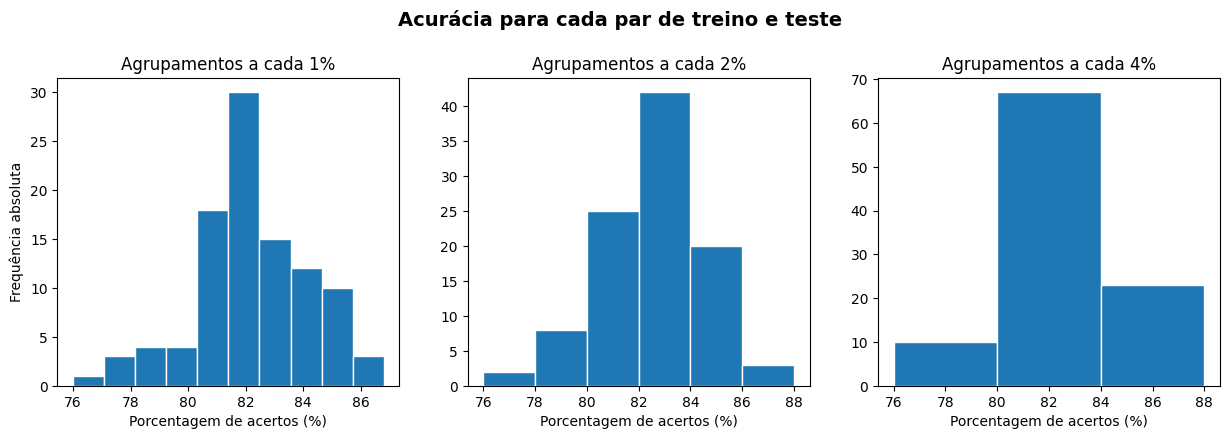

In [174]:

tamanho_fonte = 14
peso_fonte = 600
# Histogramas
plt.figure(figsize=(15, 4))
plt.suptitle('Acurácia para cada par de treino e teste',fontsize=tamanho_fonte, fontweight=peso_fonte, y=1.05)


plt.subplot(131) # Janela gráfica com 1 linha, 2 colunas e histograma a seguir é colocado na posição 1
plt.hist(dados_calculados["Acurácia"], edgecolor='white') 
plt.title("Agrupamentos a cada 1%")
plt.xlabel('Porcentagem de acertos (%)')
plt.ylabel('Frequência absoluta')


plt.subplot(132) # Janela gráfica com 1 linha, 2 colunas e histograma a seguir é colocado na posição 1
plt.hist(dados_calculados["Acurácia"], bins=[76, 78, 80, 82, 84,86,88], edgecolor='white') 
plt.title("Agrupamentos a cada 2%")
plt.xlabel('Porcentagem de acertos (%)')
# plt.ylabel('Frequência absoluta')

plt.subplot(133) # Janela gráfica com 1 linha, 2 colunas e histograma a seguir é colocado na posição 1
plt.hist(dados_calculados["Acurácia"], bins=[76, 80, 84, 88], edgecolor='white') 
plt.title("Agrupamentos a cada 4%")
plt.xlabel('Porcentagem de acertos (%)')


# plt.tight_layout()
plt.show()


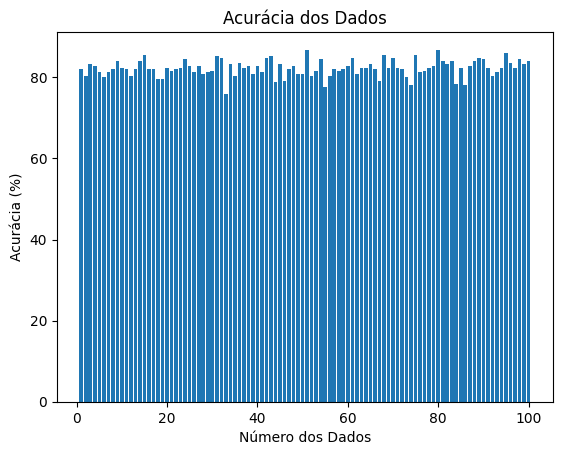

In [70]:
numeros_de_dados = list(range(1, len(acuracia) + 1))

# Crie o gráfico de barras
plt.bar(numeros_de_dados, acuracia)
plt.xlabel('Número dos Dados')
plt.ylabel('Acurácia (%)')
plt.title('Acurácia dos Dados')
plt.show()

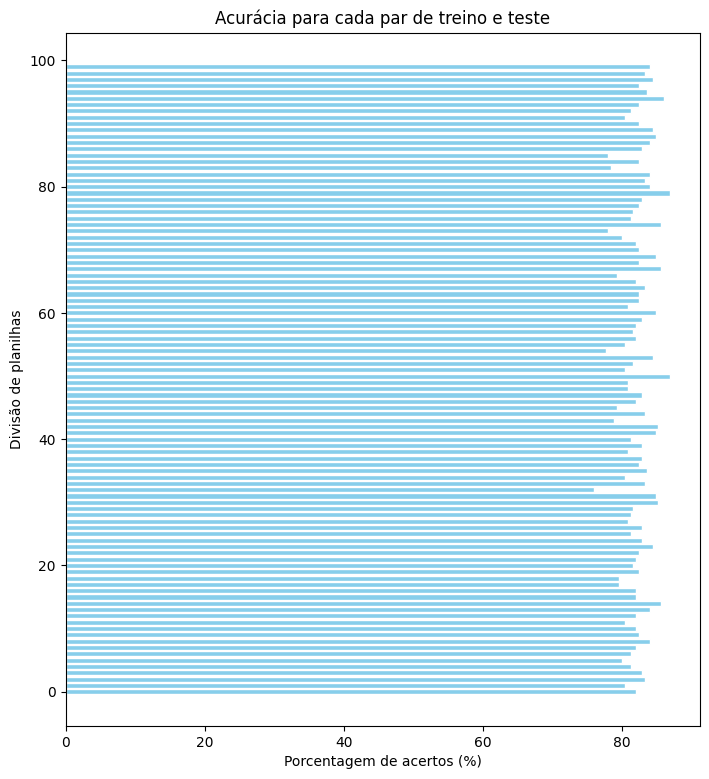

In [61]:
import matplotlib.pyplot as plt
t = np.arange(0, 100, 1)
plt.figure(figsize=(18, 9))  # Inverti o tamanho da figura para ajustar à nova orientação dos eixos

plt.subplot(121)  # Janela gráfica com 1 linha, 2 colunas e histograma a seguir é colocado na posição 1

# Invertendo os eixos e plotando o histograma
plt.barh(t, dados_calculados["Acurácia"], color='skyblue', edgecolor='white')

plt.title("Acurácia para cada par de treino e teste")
plt.xlabel('Porcentagem de acertos (%)')  # Inverti os rótulos dos eixos
plt.ylabel('Divisão de planilhas')  # Inverti os rótulos dos eixos

plt.show()


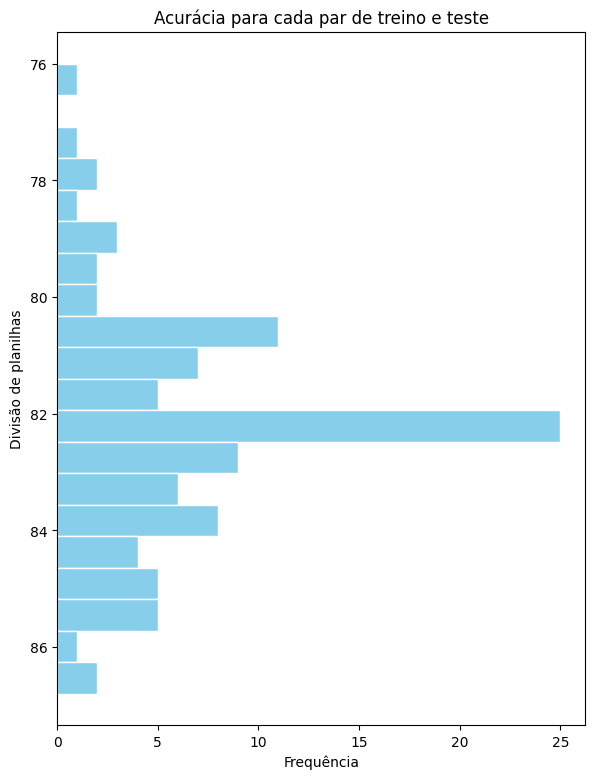

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 18/2))  # Inverti o tamanho da figura para ajustar à nova orientação dos eixos

plt.subplot(121)  # Janela gráfica com 1 linha, 2 colunas e histograma a seguir é colocado na posição 1

# Invertendo os eixos e plotando o histograma
hist_values, bin_edges, _ = plt.hist(dados_calculados["Acurácia"], bins=20, color='skyblue', edgecolor='white', orientation='horizontal')
plt.gca().invert_yaxis()  # Inverte o eixo y

plt.title("Acurácia para cada par de treino e teste")
plt.ylabel('Divisão de planilhas')  # Inverti os rótulos dos eixos
plt.xlabel('Frequência')  # Rótulo do eixo x é a frequência, pois é um histograma

plt.show()


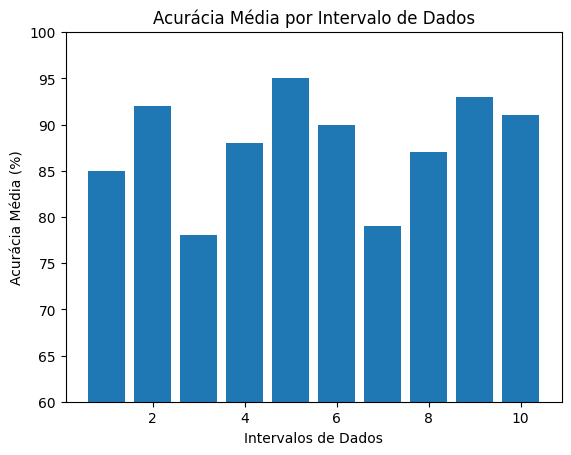

In [111]:
import matplotlib.pyplot as plt
# Defina o número de intervalos
num_intervalos = 10

# Calcule o tamanho do intervalo
tamanho_intervalo = len(acuracia) // num_intervalos

# Calcule as médias da acurácia para cada intervalo
medias_acuracia = []
for i in range(0, len(acuracia), tamanho_intervalo):
    intervalo = acuracia[i:i + tamanho_intervalo]
    media = sum(intervalo) / len(intervalo)
    medias_acuracia.append(media)

# Crie os rótulos para o eixo x
rotulos_x = np.arange(1,11,1)

# Crie o gráfico de barras com os novos rótulos do eixo x
plt.bar(rotulos_x, medias_acuracia)
plt.xlabel('Intervalos de Dados')
plt.ylabel('Acurácia Média (%)')
plt.title('Acurácia Média por Intervalo de Dados')
# plt.xticks(rotation=45)  # Rotação dos rótulos para melhor legibilidade
plt.ylim(60,100)
plt.show()

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

Dica: apresentar um grafico com testes mostrando quais limpezas melhoraram a acurácia do nosso classificador (lemmatization, stopwords, etc)

REtirar algumas palavras para ver se melhora a qualidade do classificador (exemplo palavra não)